In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import FinanceDataReader as fdr
import os 
import pickle
import xgboost
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [2]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [3]:
plt.style.use('default')

mpl.rcParams['axes.unicode_minus'] = False

# Matplotlib fontsize change
SMALL_SIZE = 15
MEDIUM_SIZE = 20
LARGE_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight='bold')
plt.rc('axes', titlesize=LARGE_SIZE, titleweight='bold')
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')
plt.rc('axes', titleweight='bold')
plt.rc('xtick', labelsize=LARGE_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)

# Save figure settings
high_dpi = 300
fig_file_ext = '.png'
Image.MAX_IMAGE_PIXELS = None  # Ignore DecompressionBombError

In [4]:
def Merge_DJI(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    DJI_df = fdr.DataReader('dji', start_date, end_date).reset_index()
    dji_df=DJI_df.drop(['Open','High','Low','Change'],axis=1)
    dji_df.rename({'Close':'dji_c','Volume':'dji_v'},axis=1,inplace=True)
    input_df=pd.merge(input_df,dji_df,how='outer',on='Date')
    
    return input_df

In [5]:
def Merge_ECR(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    exr=fdr.DataReader('USD/KRW', start_date, end_date).reset_index()
    exr=exr.drop(['Open','High','Low','Change'],axis=1)
    exr.rename({'Close':'exc_c'},axis=1,inplace=True)
    input_df=pd.merge(input_df,exr,how='outer',on='Date')
    input_df=input_df.fillna(method='ffill')
    input_df=input_df.fillna(method='bfill')
    
    return input_df

In [6]:
def Merge_hr(input_df):
    HR_3y_df=pd.read_csv("hash-rate_3y.csv")
    HR_all_df=pd.read_csv("hash-rate_alltime.csv")
    HR_df=HR_all_df.iloc[715:1255]
    HR_df=pd.concat([HR_df,HR_3y_df])
    a=pd.date_range(start=str(input_df['Date'].iloc[0]),end=str(input_df['Date'].iloc[-1]))
    HR_ori_df=pd.DataFrame(a)
    HR_ori_df.rename({0:'Timestamp'},axis=1,inplace=True)
    
    for i in range(len(HR_ori_df['Timestamp'])):
        HR_ori_df['Timestamp'].iloc[i]=str(HR_ori_df['Timestamp'].iloc[i])
        
    HR_ori_df=pd.merge(HR_ori_df,HR_df,how='outer',on='Timestamp')
    HR_ori_df=HR_ori_df[:len(a)+1]
    HR_ori_df=HR_ori_df.drop_duplicates()
    HR_ori_df=HR_ori_df.fillna(method='ffill')
    HR_ori_df=HR_ori_df.fillna(method='bfill')
    HR_ori_df.rename({'Timestamp':'Date'},axis=1,inplace=True)
    
    for i in range(len(input_df['Date'])):
        input_df['Date'].iloc[i]=str(input_df['Date'].iloc[i])
        
    input_df=pd.merge(input_df,HR_ori_df,how='outer',on='Date')
    
    return input_df

In [7]:
def preprocessing(input_df, len_lag) :
    # 이동평균선 추가 5,10,20
    moving_avg=[5,10,20]
    for i in moving_avg:
        input_df[f'{i}_close']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'{i}_close']=input_df['c'].rolling(window=i).mean()
        
    # p_lag:과거 가격, q_lag:과거 거래량 추가, pq_lag:거래대금 
    for lag in range(1,len_lag+1):
        input_df[f'p_lag_{lag}'] = -1
        input_df[f'q_lag_{lag}'] = -1 
        input_df[f'pq_lag_{lag}'] = -1
        for index in range(lag, len(input_df)):
            input_df.loc[index, f'p_lag_{lag}'] = input_df['c'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            input_df.loc[index, f'q_lag_{lag}'] = input_df['v'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
            input_df.loc[index, f'pq_lag_{lag}'] = (input_df['c'][index-lag]*input_df['v'][index-lag]) #1일전, 2일전, ... 거래량을 feature로 추가

In [8]:
def OBV_preprocessing(input_df):
    # OBV 산출 및 데이터 프레임에 추가 
    OBV=[]
    OBV.append(0)
    for i in range(1,len(input_df)):
        if input_df['c'].iloc[i] > input_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]+input_df['v'].iloc[i])
        elif price_df['c'].iloc[i]<input_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]-input_df['v'].iloc[i]) 
        else:
            OBV.append(OBV[-1])
            
    # OBV 추가
    input_df['obv']=OBV
    
    # 지수 평균 이동값 계산 
    input_df['obv_ema']=input_df['obv'].ewm(com=20).mean()
    
    # obv가 보통 지수를 위로 뚫으면 매수 신호 아래로 뚫으면 매도 신호 
    input_df['signal_obv']=input_df['obv']-input_df['obv_ema']
    
    moving_avg=[5,20,30]
    for i in moving_avg:
        input_df[f'obv_lag{i}']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'obv_lag{i}']=input_df['signal_obv'].rolling(window=i).mean()

In [9]:
def gen_train_test2(input_df):
    input_df['target']=0
    for i in range(len(input_df)-1):
        input_df['target'].iloc[i]=input_df['c'].iloc[i+1]

In [10]:
with open("btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    df=df.reset_index()
    df.rename({'ot':'Date'},axis=1,inplace=True)
df

,Date,o,h,l,c,v
0,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
1,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
3,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
4,2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...,...
2609,2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2610,2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2611,2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03
2612,2022-01-23,35084.79,36574.47,34624.59,36293.62,2.533704e+03


In [11]:
test_df=df[:]
test_df=Merge_DJI(test_df)
test_df=Merge_ECR(test_df)
test_df=Merge_hr(test_df)
price_df=test_df[:]
OBV_preprocessing(price_df)
preprocessing(price_df,10)
gen_train_test2(price_df)
price_df
price_df=price_df.drop(['h','l'],axis=1)

In [12]:
final_price_df=price_df[31:2604]
len(final_price_df)

2573

In [13]:
final_price_df.set_index('Date',inplace=True,drop=True)

In [14]:
final_price_df

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-30 00:00:00,314.78,311.94,3.091942e+06,17983.07,47490000.0,1096.92,2.863719e+05,-1.419967e+07,-7.861093e+06,-6.338578e+06,...,330.52,3.821126e+06,1.262959e+09,323.15,2.114708e+06,6.833678e+08,329.99,3.617197e+06,1.193639e+09,319.25
2014-12-31 00:00:00,311.94,319.25,1.925335e+06,17823.07,82840000.0,1093.90,2.863719e+05,-1.227434e+07,-8.123744e+06,-4.150592e+06,...,335.49,2.604314e+06,8.737214e+08,330.52,3.821126e+06,1.262959e+09,323.15,2.114708e+06,6.833678e+08,316.31
2015-01-01 00:00:00,319.25,316.31,1.018388e+06,17823.07,82840000.0,1092.45,2.863719e+05,-1.329272e+07,-8.427756e+06,-4.864968e+06,...,322.14,1.826465e+06,5.883775e+08,335.49,2.604314e+06,8.737214e+08,330.52,3.821126e+06,1.262959e+09,316.51
2015-01-02 00:00:00,316.31,316.51,1.093572e+06,17832.99,76270000.0,1106.92,3.232437e+05,-1.219915e+07,-8.647114e+06,-3.552039e+06,...,319.39,1.255322e+06,4.009373e+08,322.14,1.826465e+06,5.883775e+08,335.49,2.604314e+06,8.737214e+08,286.01
2015-01-03 00:00:00,316.51,286.01,6.078845e+06,17832.99,76270000.0,1106.92,3.232437e+05,-1.827800e+07,-9.201435e+06,-9.076563e+06,...,330.88,2.066944e+06,6.839105e+08,319.39,1.255322e+06,4.009373e+08,322.14,1.826465e+06,5.883775e+08,264.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,47350.22,7.020948e+02,3.324434e+07,47777.42,7.415206e+02,3.542794e+07,46214.37,1.798553e+03,8.311898e+07,42736.00
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,46439.89,1.140179e+03,5.294979e+07,47350.22,7.020948e+02,3.324434e+07,47777.42,7.415206e+02,3.542794e+07,43933.50
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,45820.00,1.832613e+03,8.397032e+07,46439.89,1.140179e+03,5.294979e+07,47350.22,7.020948e+02,3.324434e+07,42571.94


In [15]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]


def backtest_XGB_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft-1], batch_df[ft-1:ft]
            X_train, y_train = train.drop('target',axis=1,inplace=False),train['target']
            X_test, y_test = test.drop('target',axis=1,inplace=False),test['target']
            xgb = XGBRegressor()
            xgb.fit(X_train, y_train)
            pred = xgb.predict(X_test)
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].o
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['c'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['c'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

2273it [09:12,  4.11it/s]


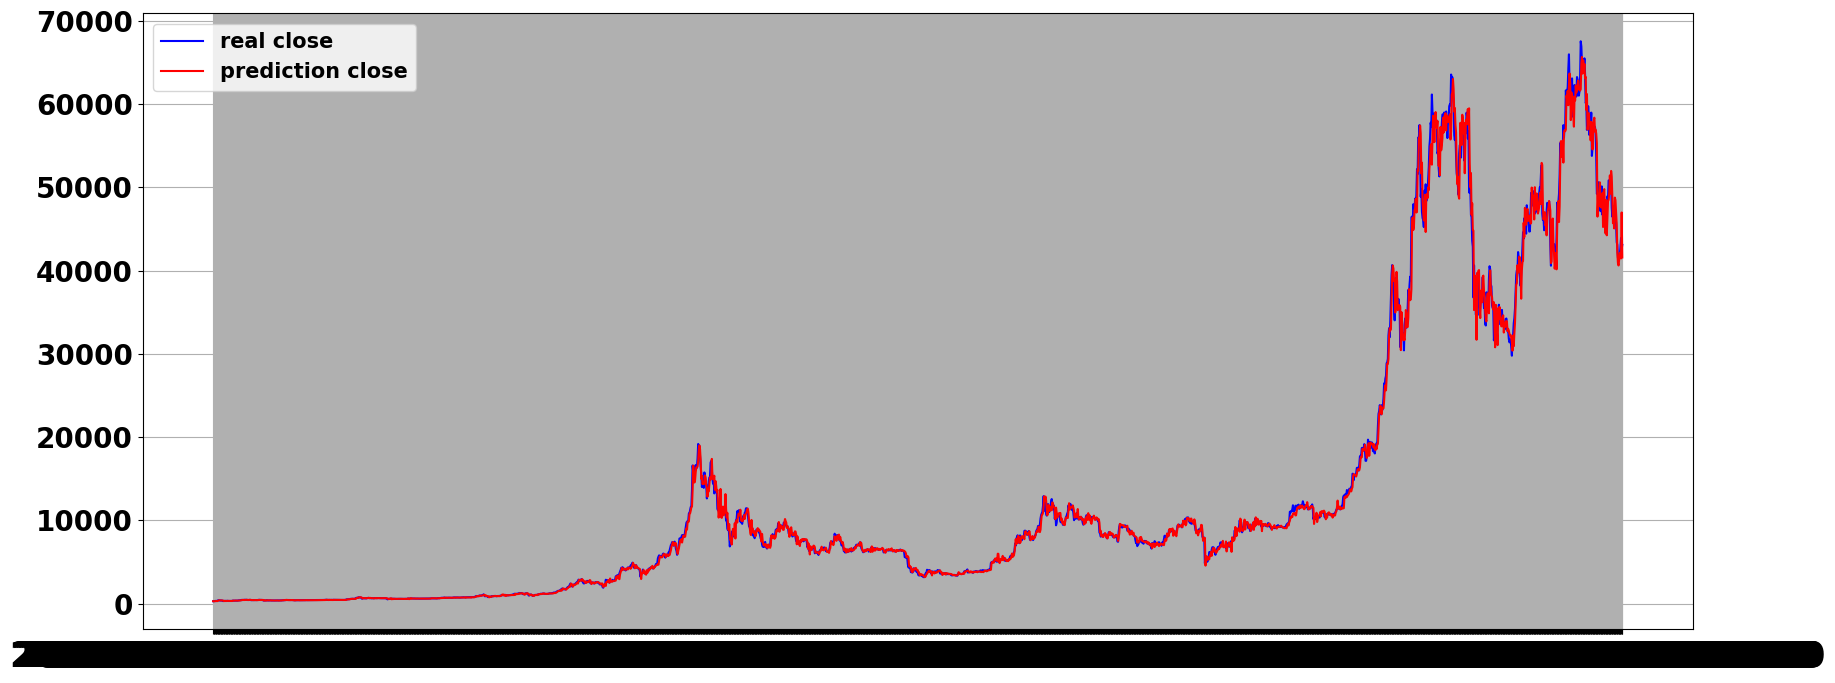

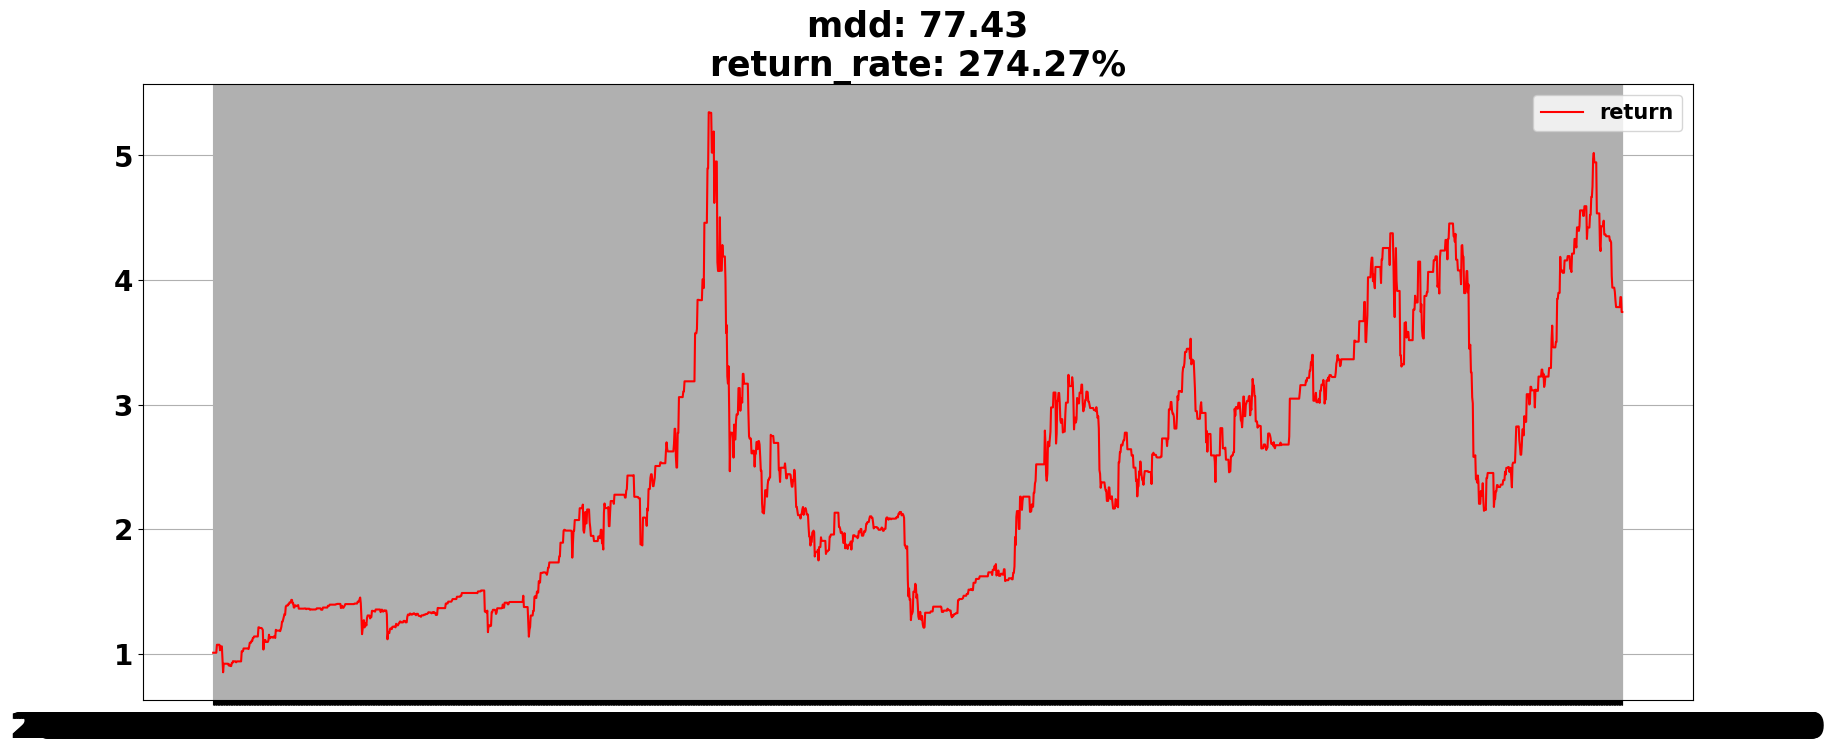

In [16]:
result_df = backtest_XGB_1d(final_price_df,300, 1)

In [17]:
analysis_return(result_df)

{'trade_rate': ' 45.49%',
 'success_rate': ' 53.87%',
 'pnl_rate': ' 1.17',
 'mdd': ' 77.43%',
 'cr': ' 274.27%'}

In [18]:
result_df

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2015-10-26 00:00:00,283.96,285.82,5.898922e+06,17623.05,116660000.0,1129.63,4.600358e+05,4.041578e+07,-4.801669e+06,4.521745e+07,...,262.50,8.783403e+06,2.305643e+09,295.17,298.828339,283.96,1,1.006550,1.006550,0.000000
2015-10-27 00:00:00,286.90,295.17,9.867603e+06,17581.43,115180000.0,1136.14,4.600358e+05,5.028338e+07,-2.178571e+06,5.246195e+07,...,268.99,6.740959e+06,1.813250e+09,304.05,284.829742,286.90,0,1.000000,1.006550,0.000000
2015-10-28 00:00:00,295.59,304.05,9.258154e+06,17779.52,115630000.0,1145.60,4.600358e+05,5.954153e+07,7.604816e+05,5.878105e+07,...,261.00,2.553365e+06,6.664283e+08,313.73,287.084045,295.59,0,1.000000,1.006550,0.000000
2015-10-29 00:00:00,304.77,313.73,9.831880e+06,17755.80,90300000.0,1142.19,4.580100e+05,6.937341e+07,4.027764e+06,6.534565e+07,...,264.43,4.289134e+06,1.134176e+09,328.78,290.802429,304.77,0,1.000000,1.006550,0.000000
2015-10-30 00:00:00,314.95,328.78,1.236748e+07,17663.54,149250000.0,1141.16,4.580100e+05,8.174089e+07,7.728390e+06,7.401250e+07,...,270.23,7.638165e+06,2.064061e+09,310.06,303.111786,314.95,0,1.000000,1.006550,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,42146.078125,41853.98,1,0.999795,3.781750,29.270172
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,41954.867188,41842.22,1,1.021361,3.862530,27.759331
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41469.175781,42754.44,0,1.000000,3.862530,27.759331
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46993.347656,43935.01,1,0.968975,3.742697,30.000576


2023it [13:30,  2.50it/s]


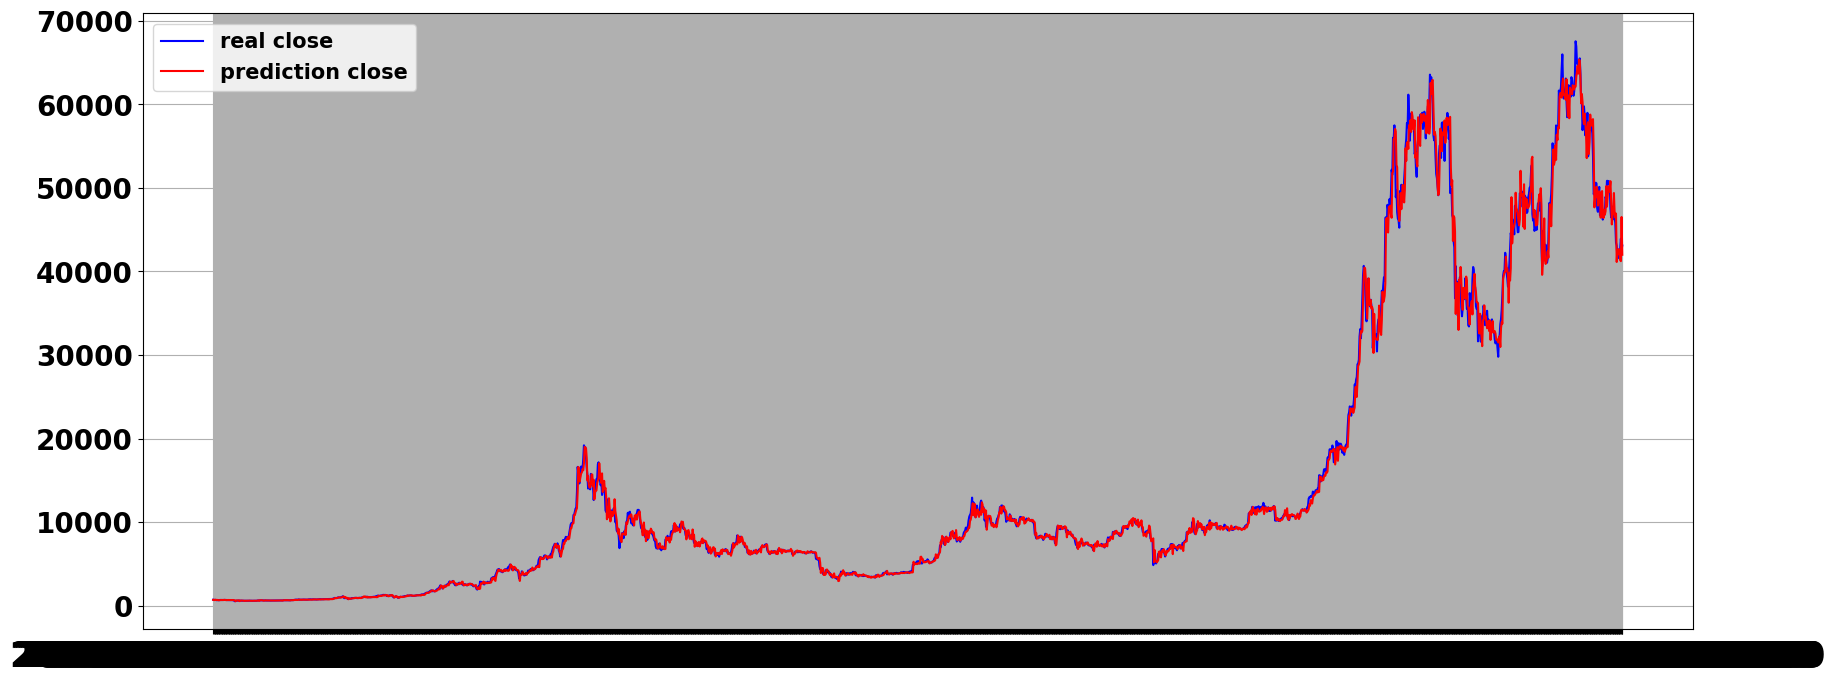

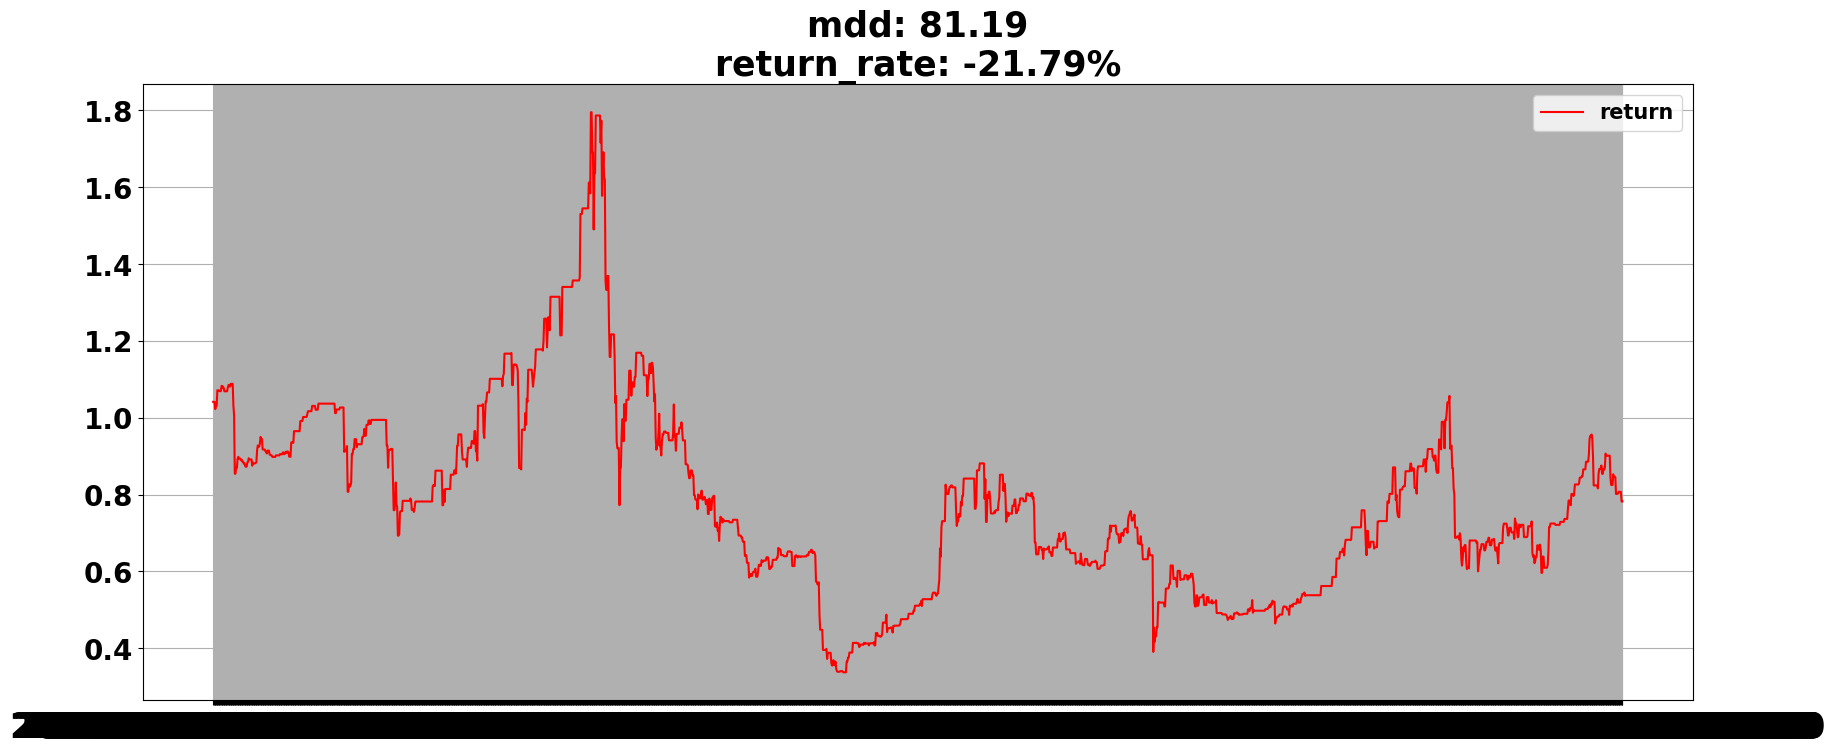

In [22]:
result_df1 = backtest_XGB_1d(final_price_df,550, 1)

In [23]:
analysis_return(result_df1)

{'trade_rate': ' 43.40%',
 'success_rate': ' 54.33%',
 'pnl_rate': ' 1.05',
 'mdd': ' 81.19%',
 'cr': '-21.79%'}

In [24]:
result_df1

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2016-07-02 00:00:00,674.55,702.48,3.759346e+06,17949.37,82160000.0,1150.00,1.634680e+06,2.256623e+08,2.049238e+08,2.073850e+07,...,594.10,9.966792e+06,5.921271e+09,664.14,679.055908,674.55,1,1.041405,1.041405,0.000000
2016-07-03 00:00:00,702.48,664.14,4.835675e+06,17949.37,82160000.0,1150.00,1.634680e+06,2.208266e+08,2.056810e+08,1.514555e+07,...,624.69,1.398286e+07,8.734954e+09,678.72,691.148132,702.48,0,1.000000,1.041405,0.000000
2016-07-04 00:00:00,659.77,678.72,2.796115e+06,17949.37,82160000.0,1152.14,1.601826e+06,2.236227e+08,2.065354e+08,1.708730e+07,...,656.71,1.049301e+07,6.890864e+09,666.58,652.131836,659.77,0,1.000000,1.041405,0.000000
2016-07-05 00:00:00,678.74,666.58,2.084269e+06,17840.62,103670000.0,1159.05,1.601826e+06,2.215384e+08,2.072498e+08,1.428860e+07,...,663.24,4.363899e+06,2.894312e+09,674.46,702.687134,678.74,1,0.982084,1.022748,1.791555
2016-07-06 00:00:00,669.09,674.46,2.379340e+06,17918.62,93000000.0,1159.45,1.601826e+06,2.239178e+08,2.080436e+08,1.587423e+07,...,628.61,3.320432e+06,2.087257e+09,636.39,672.306580,669.09,1,1.008026,1.030956,1.003351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,42100.132812,41853.98,1,0.999795,0.807139,55.035473
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,41386.769531,41842.22,0,1.000000,0.807139,55.035473
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41233.332031,42754.44,0,1.000000,0.807139,55.035473
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46522.648438,43935.01,1,0.968975,0.782097,56.430484


2373it [07:37,  5.19it/s]


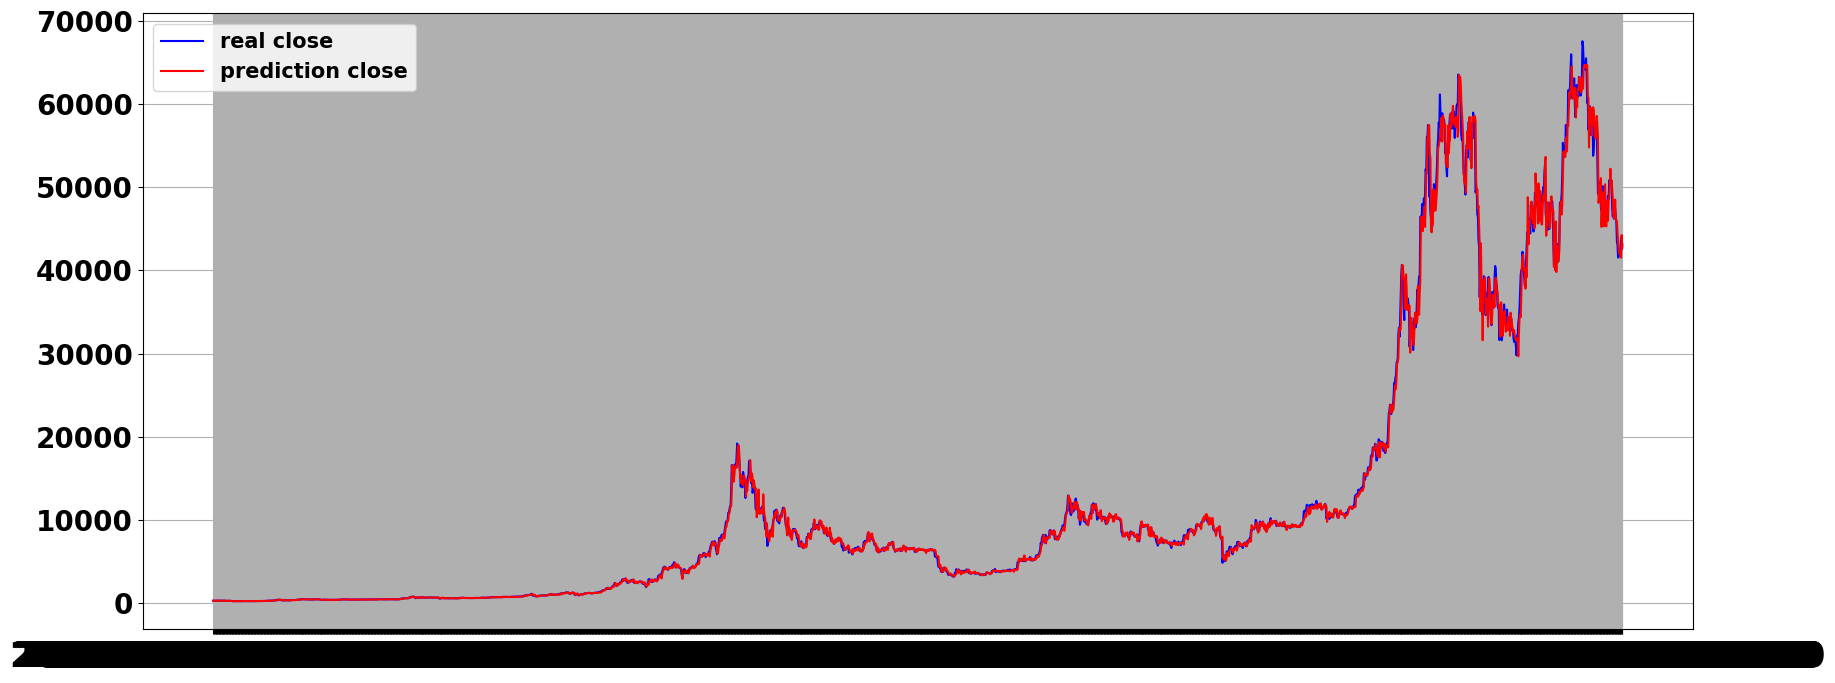

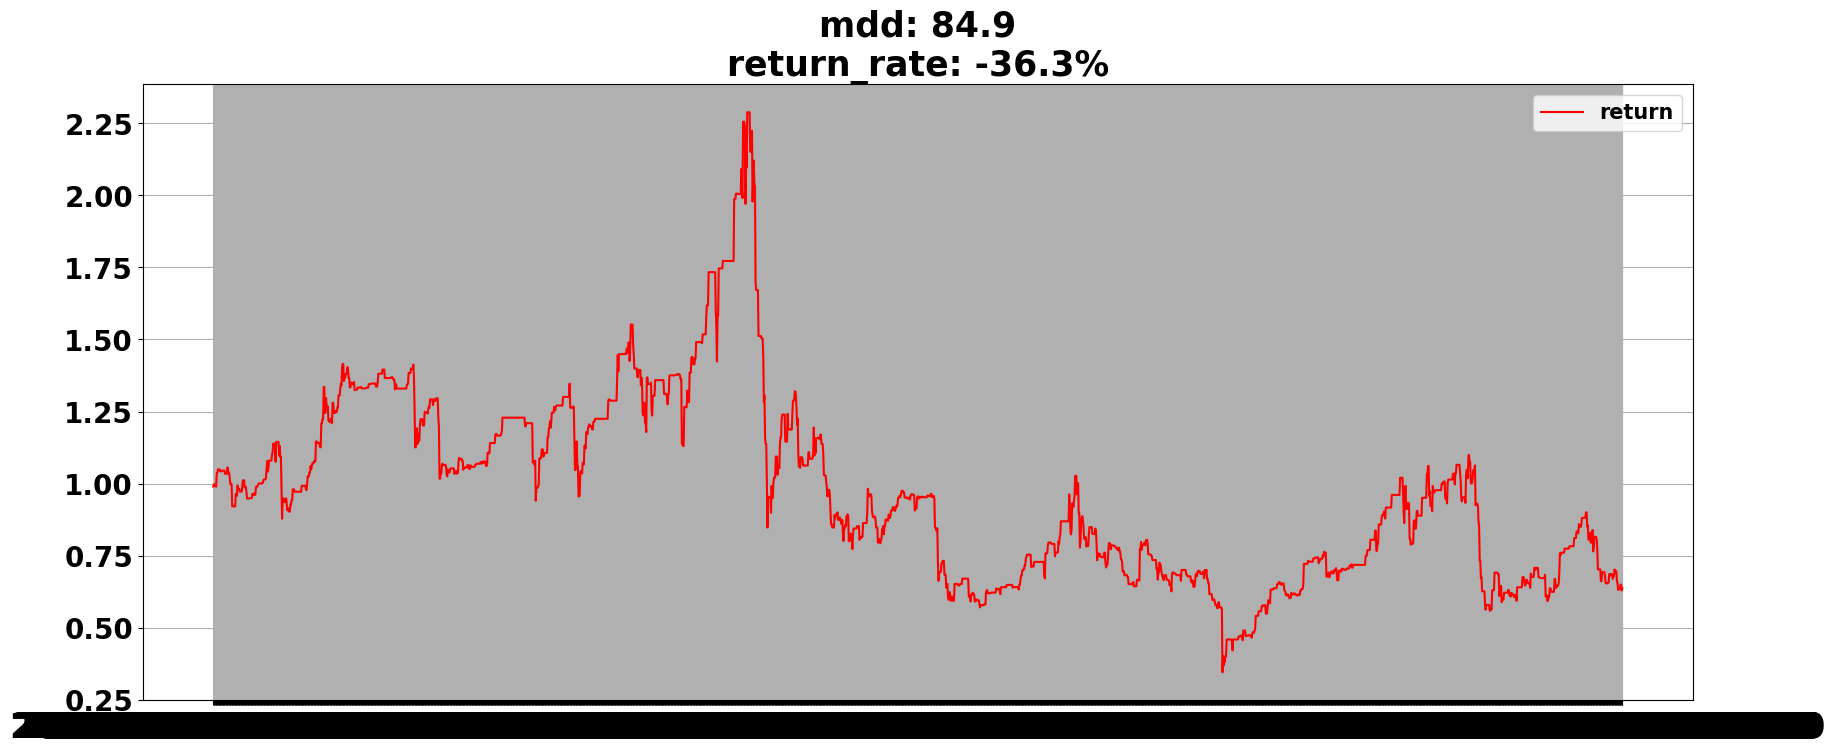

In [25]:
result_df2 = backtest_XGB_1d(final_price_df,200, 1)

In [26]:
analysis_return(result_df2)

{'trade_rate': ' 45.60%',
 'success_rate': ' 52.50%',
 'pnl_rate': ' 1.04',
 'mdd': ' 84.90%',
 'cr': '-36.30%'}

2323it [08:18,  4.66it/s]


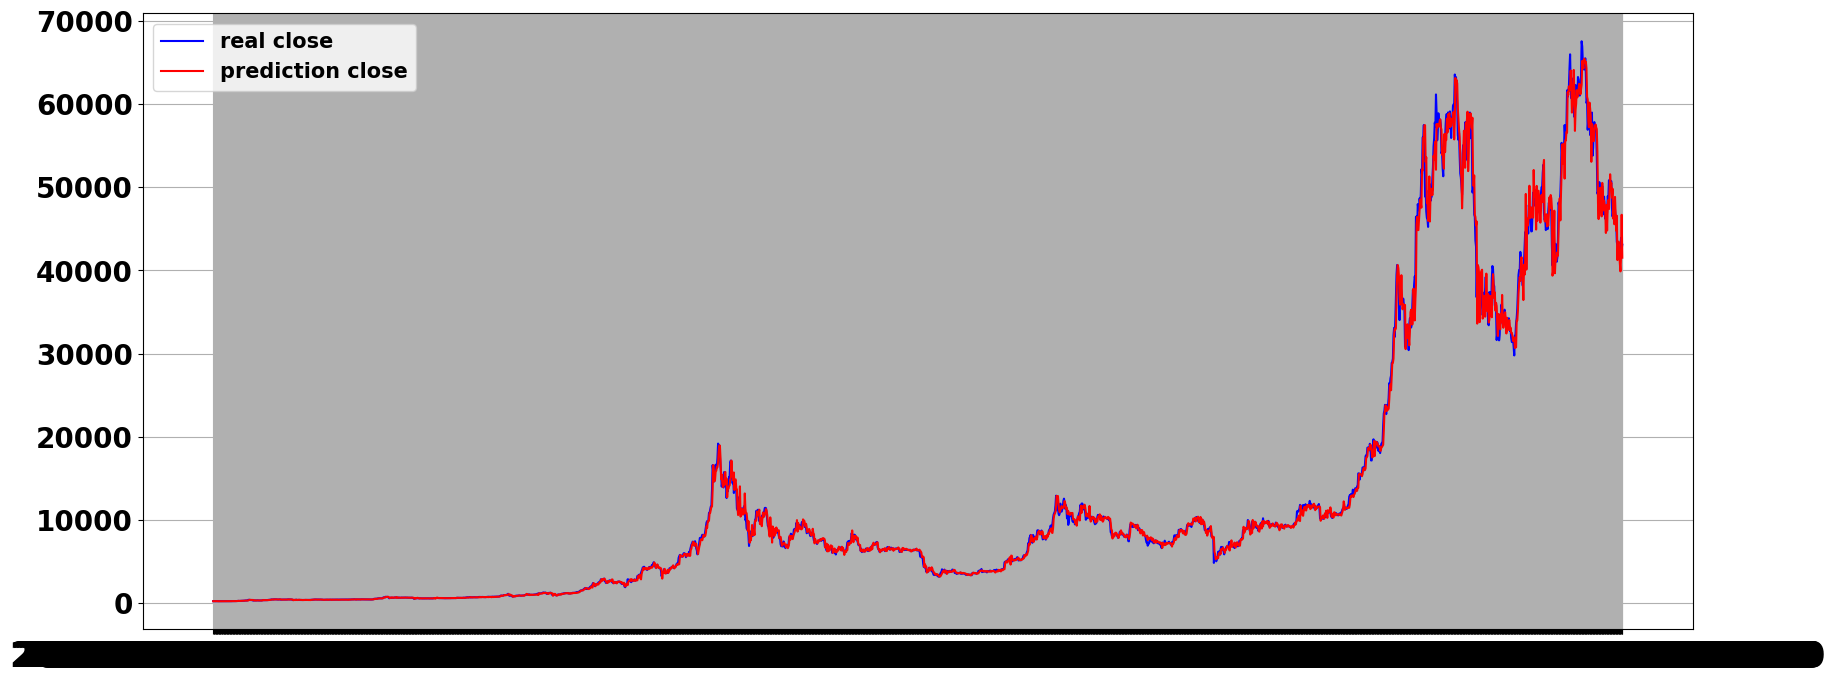

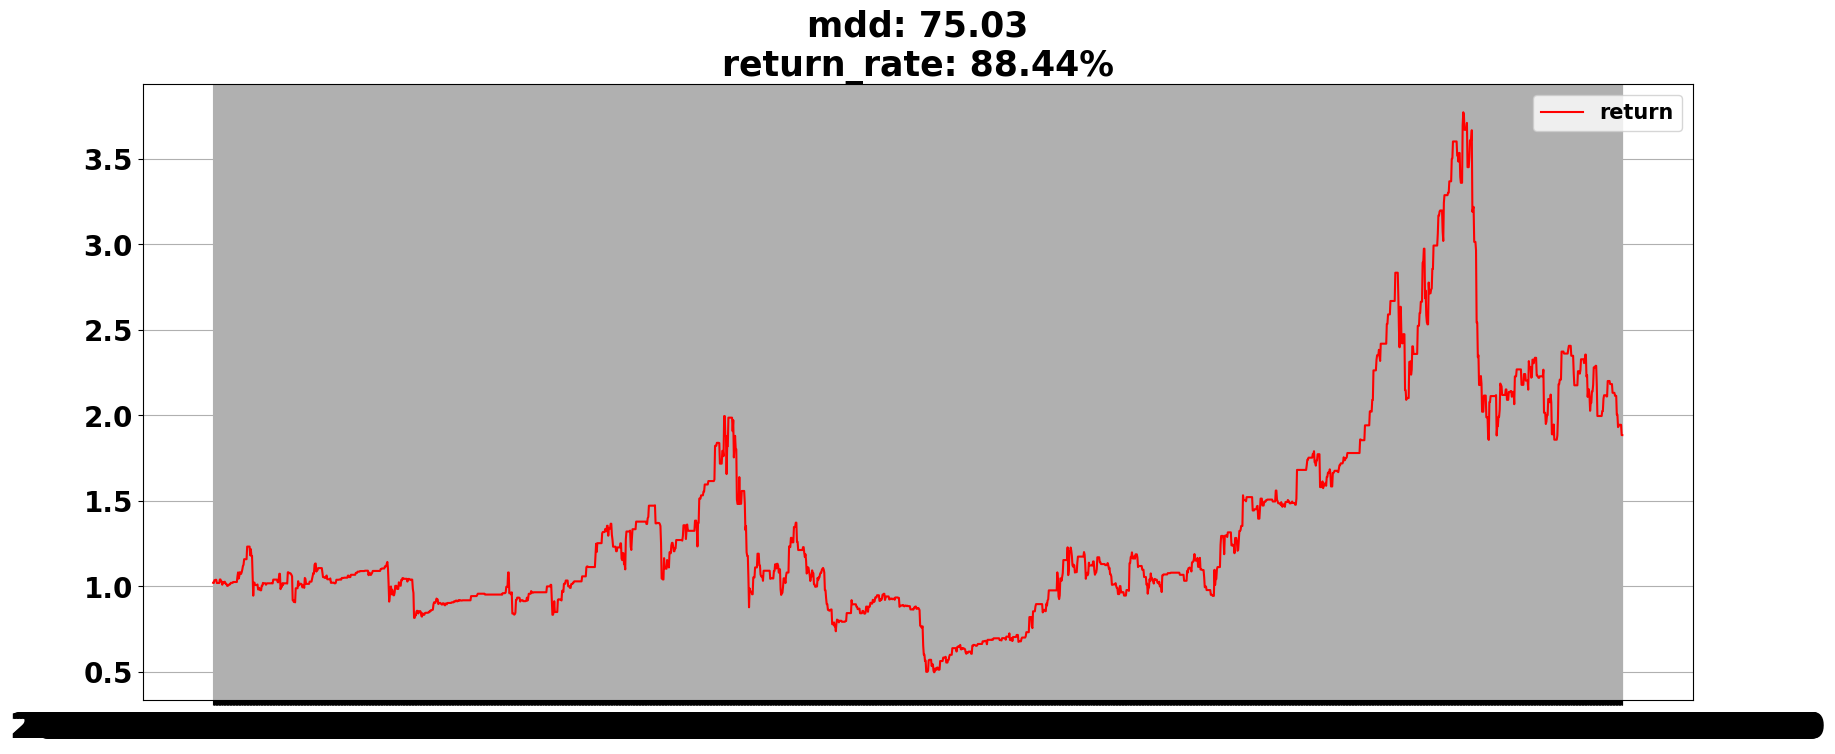

In [33]:
result_df3 = backtest_XGB_1d(final_price_df,250, 1)

In [34]:
analysis_return(result_df3)

{'trade_rate': ' 45.59%',
 'success_rate': ' 54.11%',
 'pnl_rate': ' 1.11',
 'mdd': ' 75.03%',
 'cr': ' 88.44%'}

2473it [05:24,  7.62it/s]


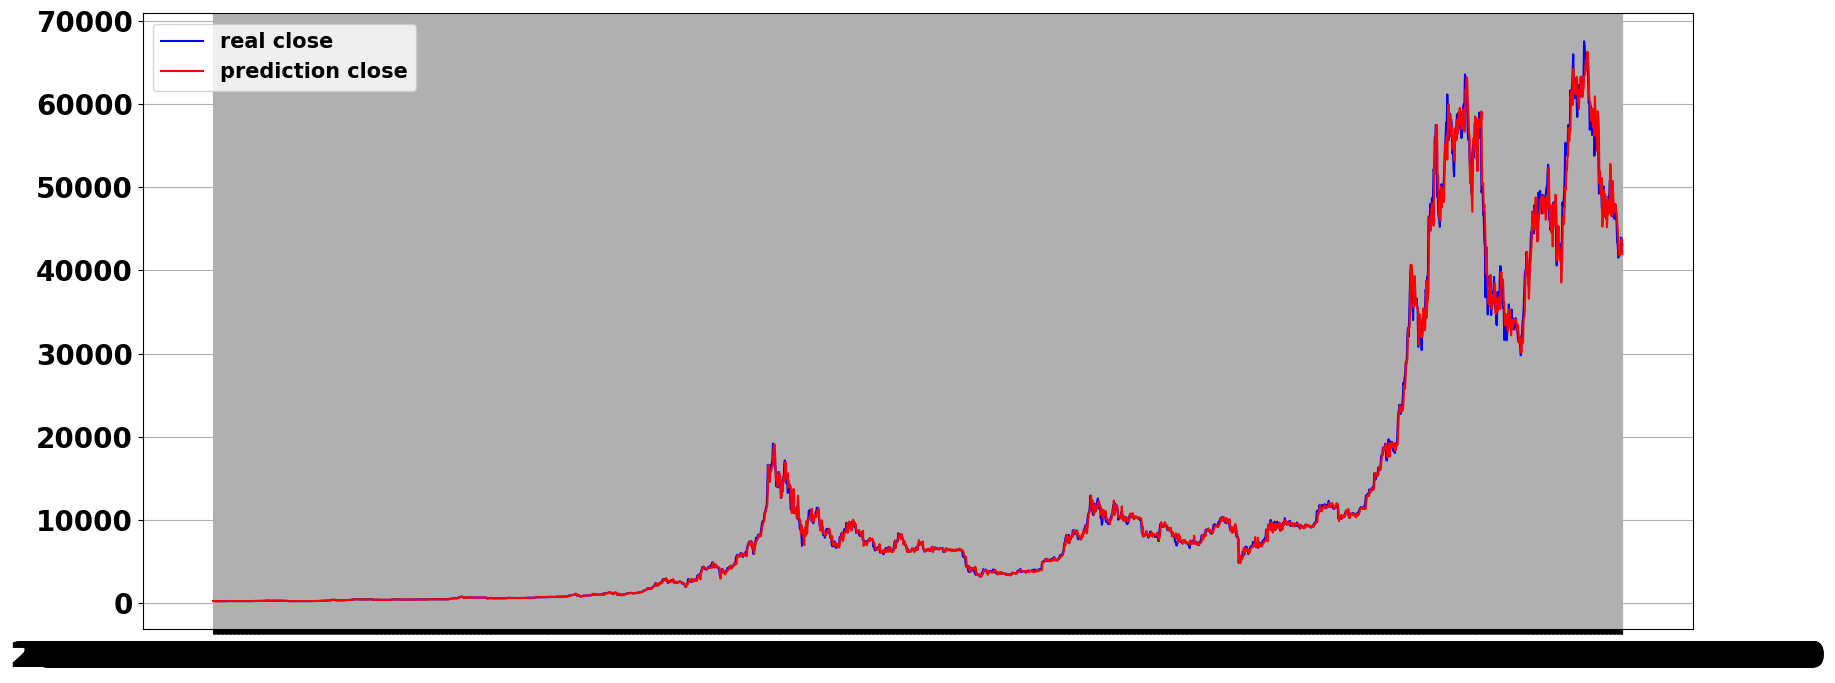

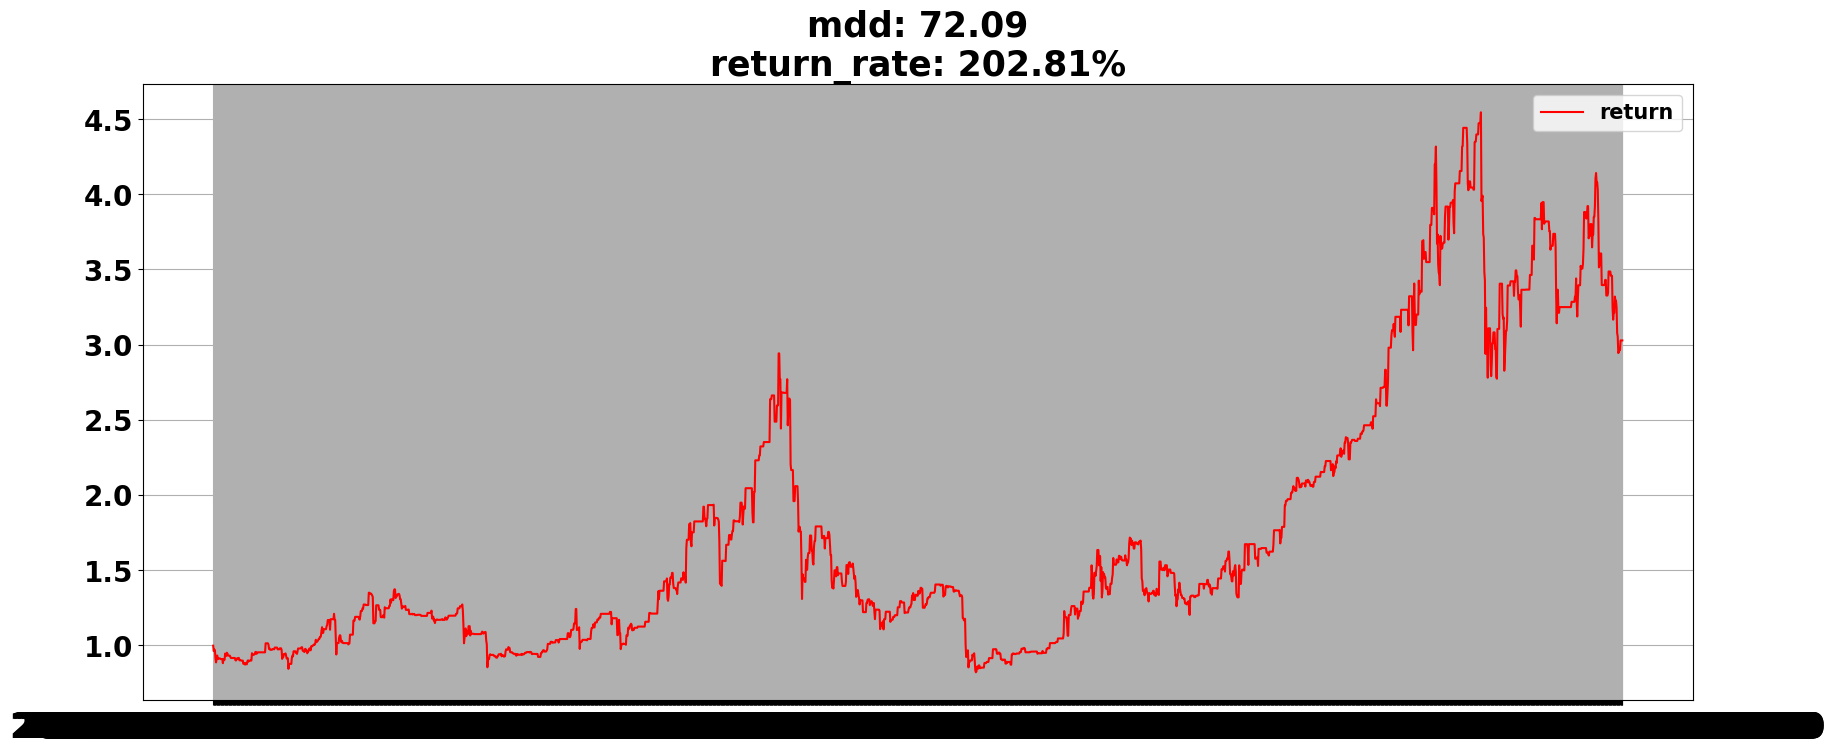

In [29]:
result_df4 = backtest_XGB_1d(final_price_df,100, 1)

In [30]:
analysis_return(result_df4)

{'trade_rate': ' 45.49%',
 'success_rate': ' 54.22%',
 'pnl_rate': ' 1.14',
 'mdd': ' 72.09%',
 'cr': ' 202.81%'}

2523it [04:19,  9.72it/s]


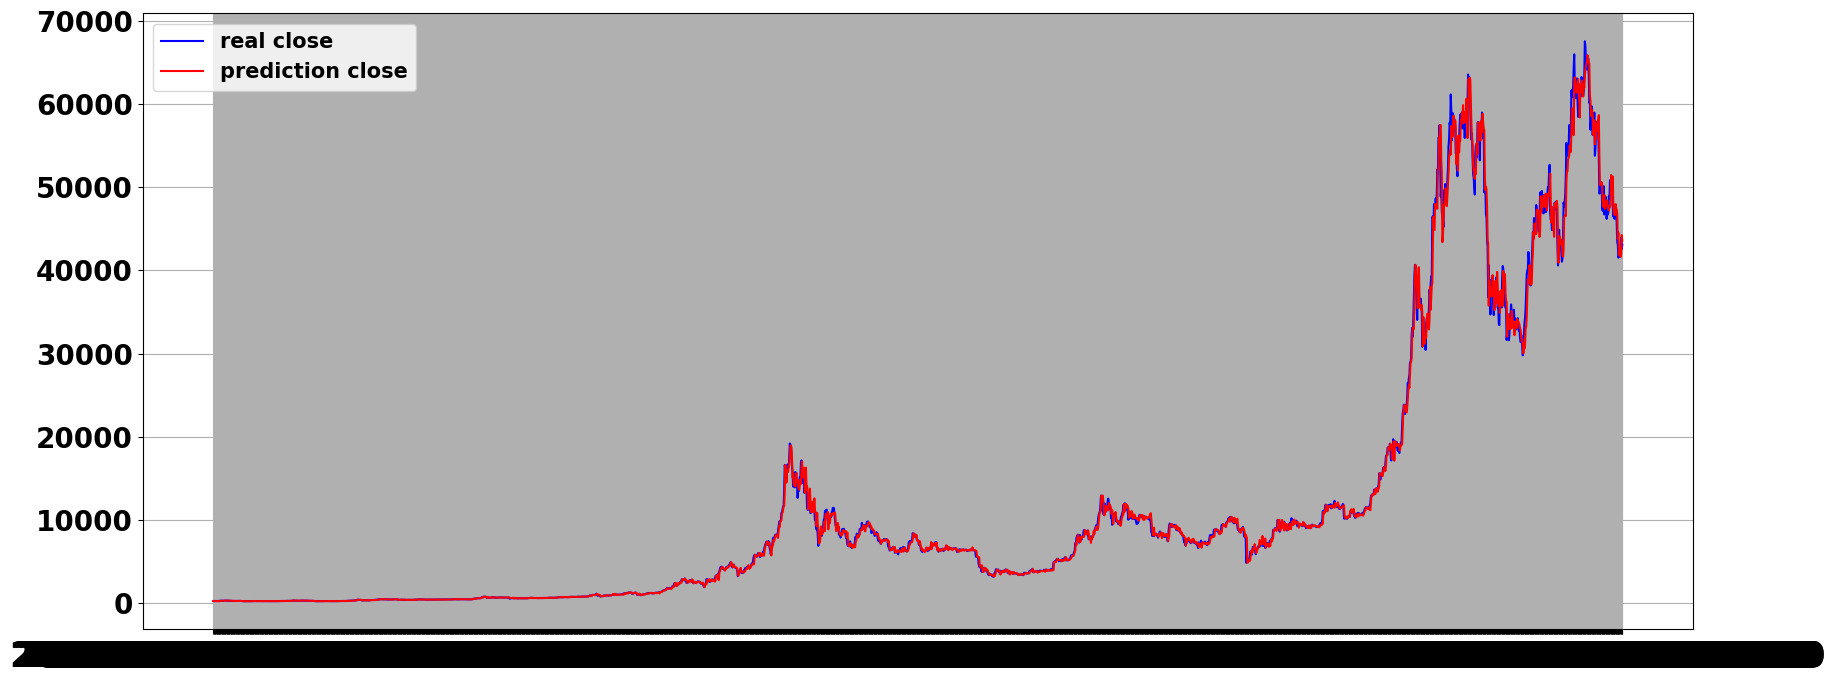

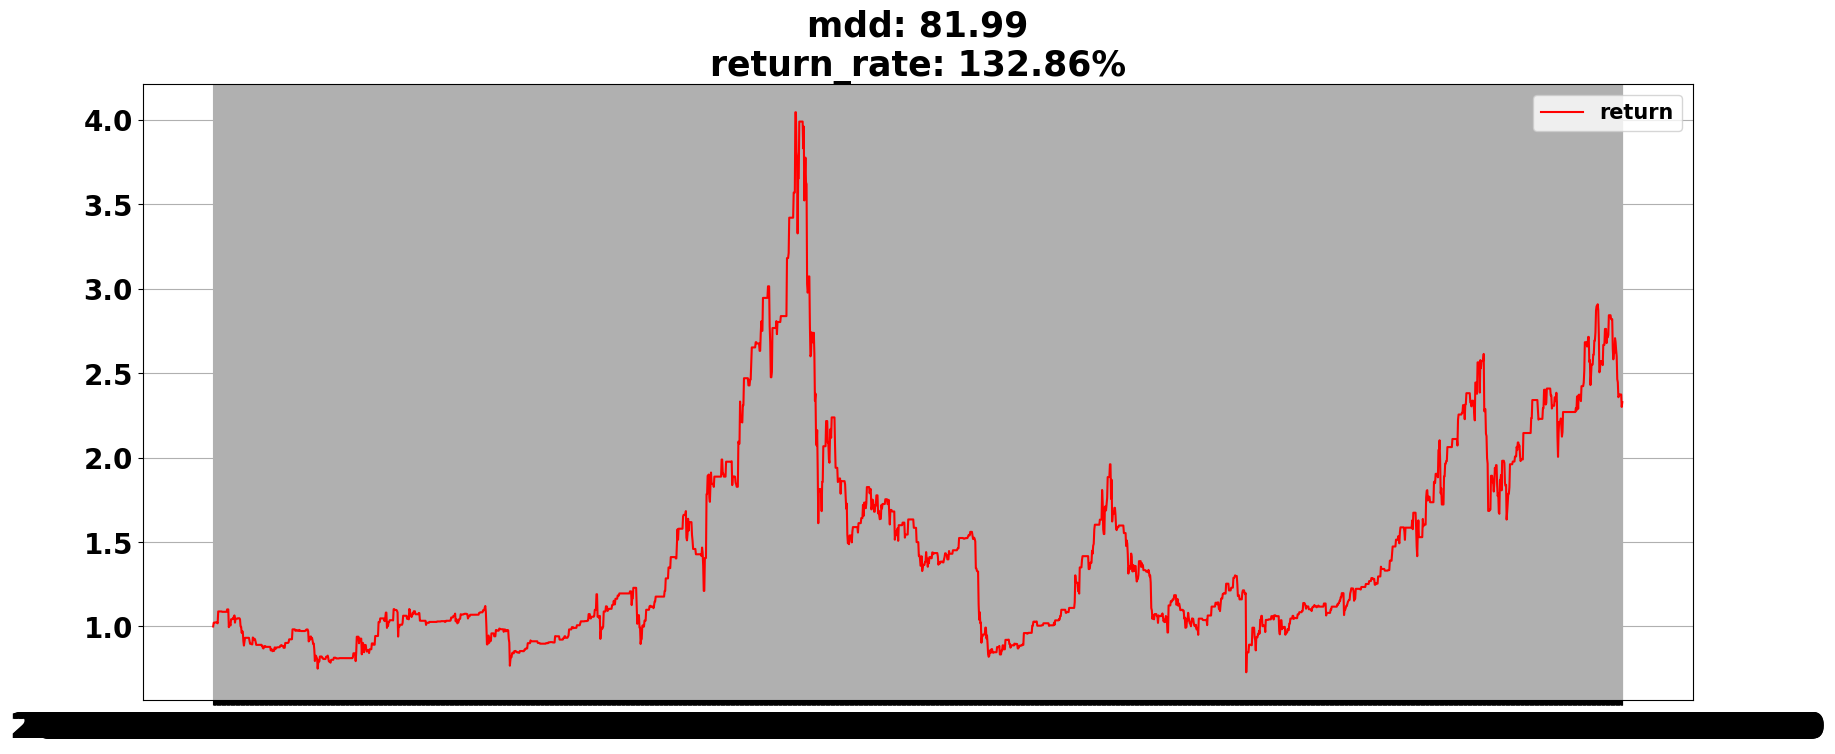

In [31]:
result_df5 = backtest_XGB_1d(final_price_df,50, 1)

In [32]:
analysis_return(result_df5)

{'trade_rate': ' 44.95%',
 'success_rate': ' 54.67%',
 'pnl_rate': ' 1.13',
 'mdd': ' 81.99%',
 'cr': ' 132.86%'}

2223it [10:36,  3.49it/s]


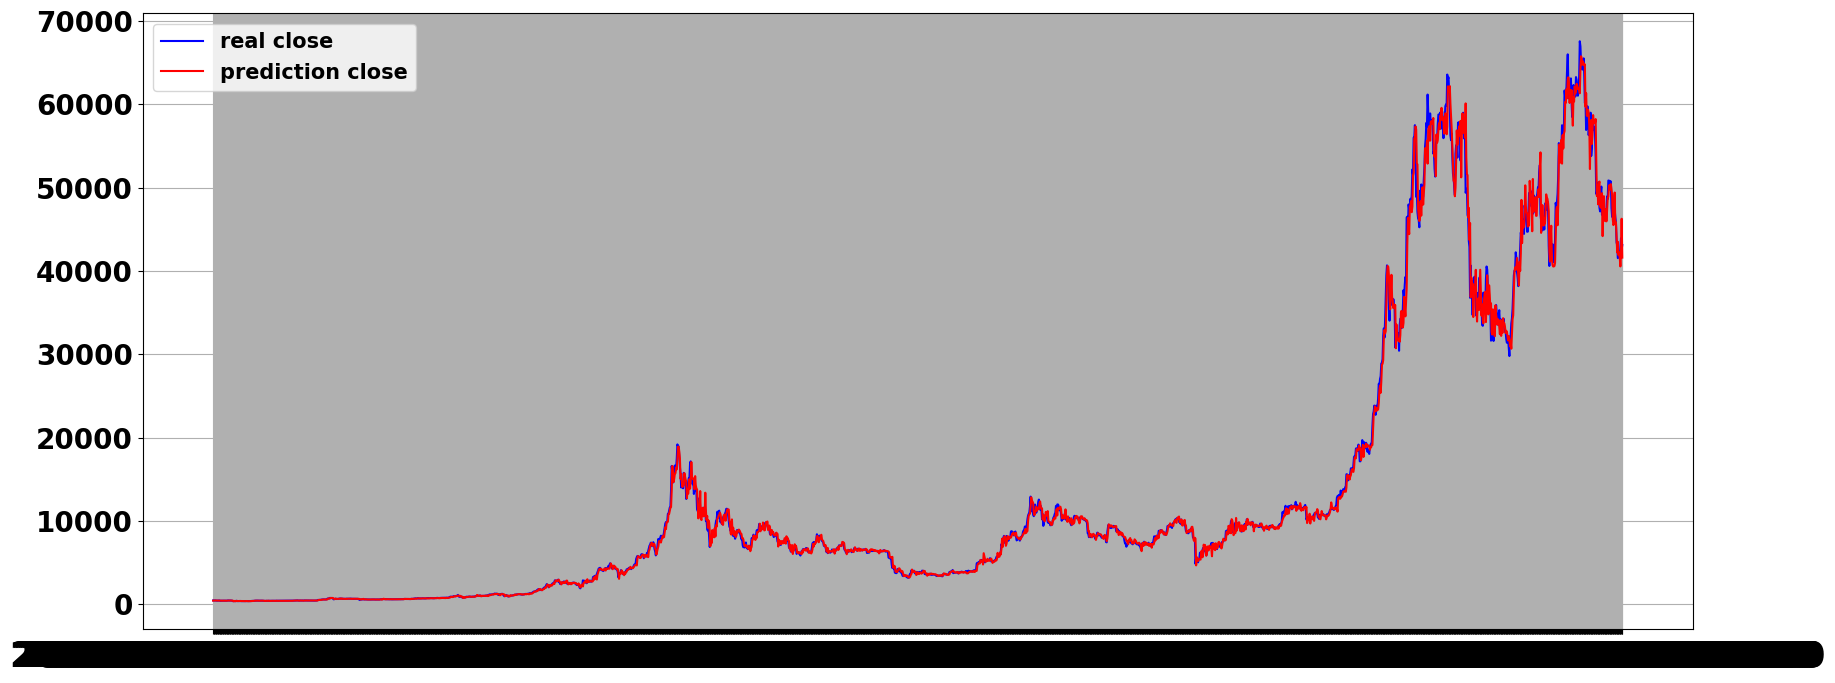

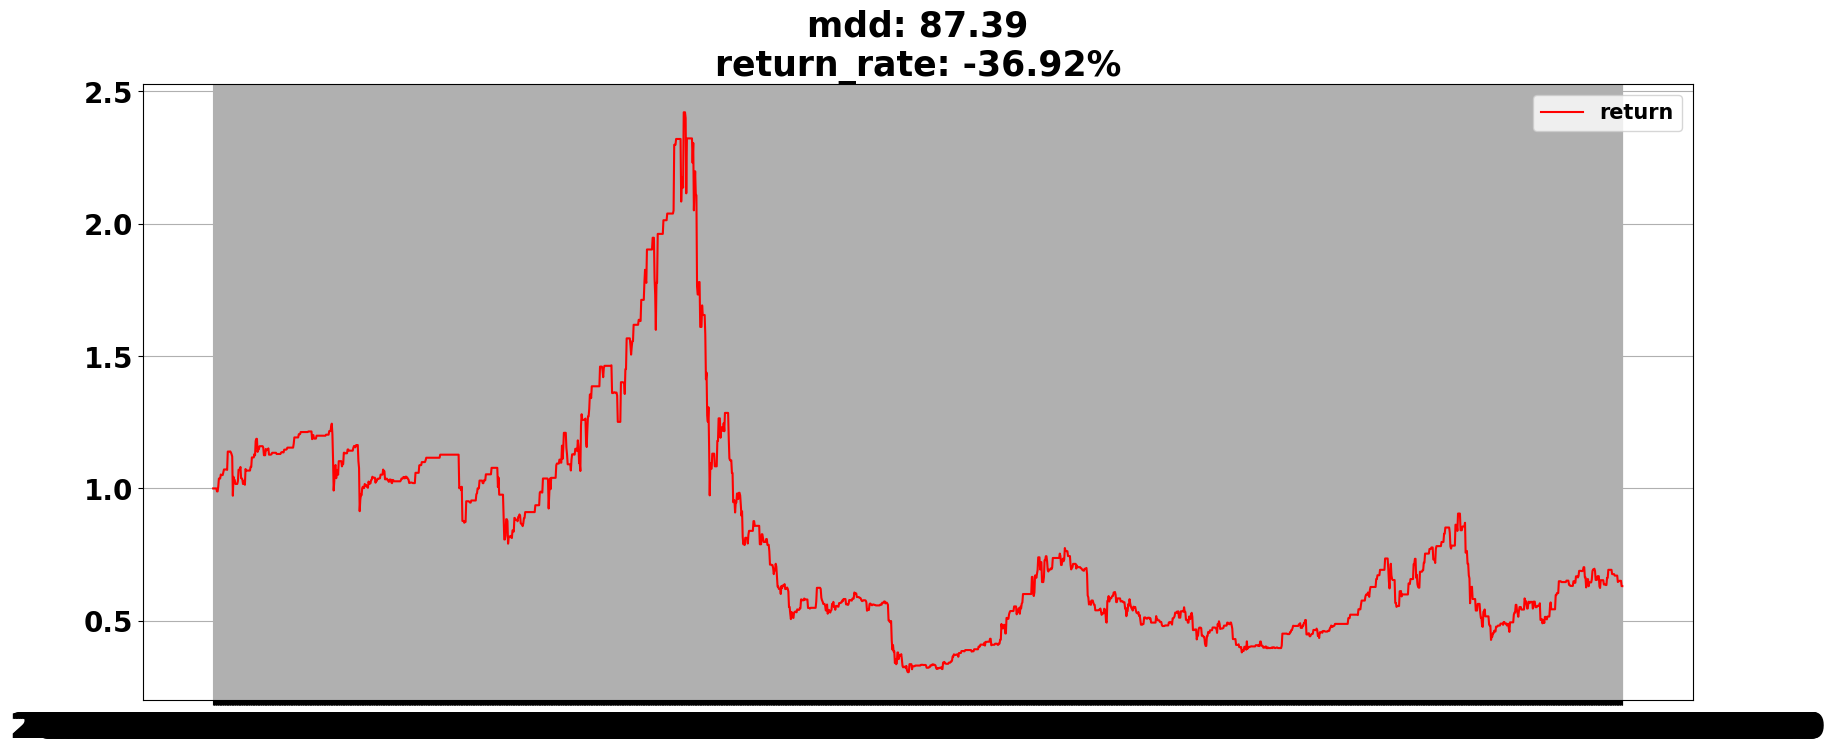

In [16]:
result_df6 = backtest_XGB_1d(final_price_df,350, 1)

In [17]:
analysis_return(result_df6)

{'trade_rate': ' 46.96%',
 'success_rate': ' 51.63%',
 'pnl_rate': ' 1.03',
 'mdd': ' 87.39%',
 'cr': '-36.92%'}

2173it [10:16,  3.53it/s]


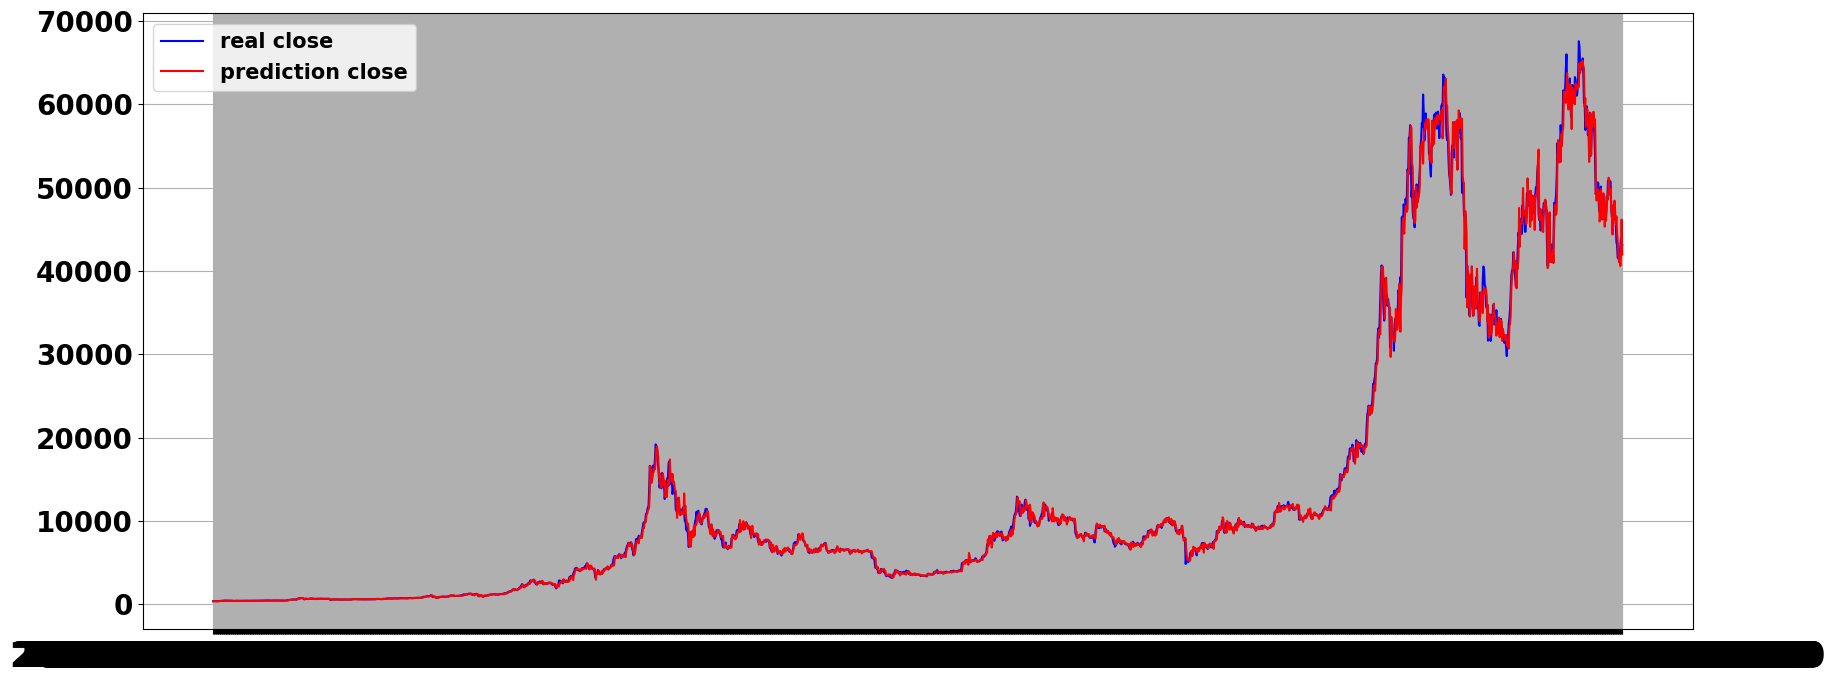

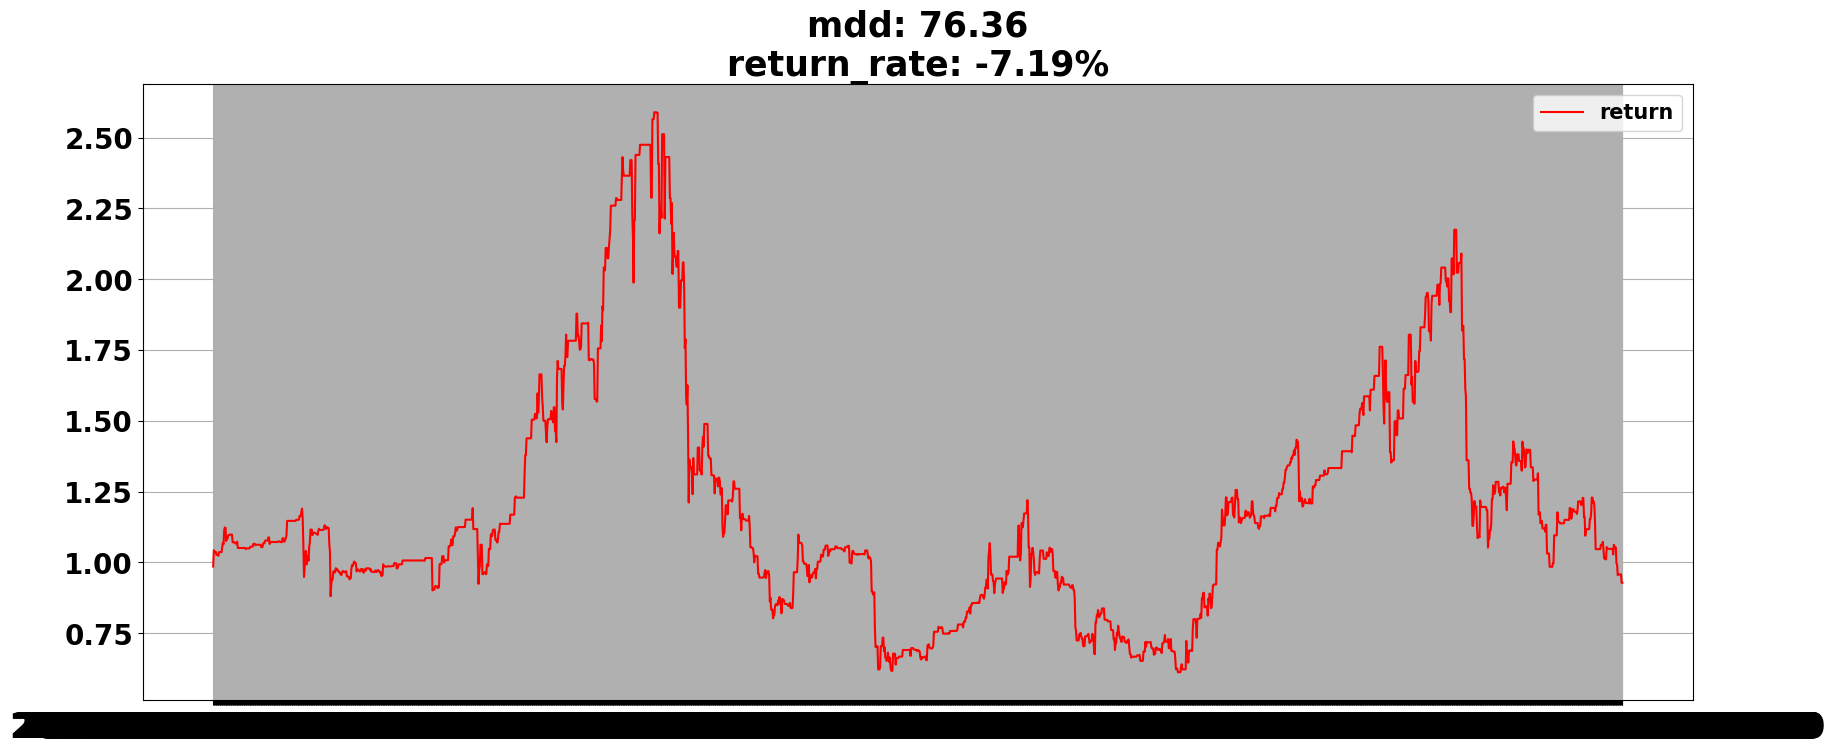

In [18]:
result_df7 = backtest_XGB_1d(final_price_df,400, 1)

In [19]:
result_df7 

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2016-02-03 00:00:00,373.05,367.64,2.602788e+06,16336.66,141870000.0,1201.14,9.785699e+05,1.221654e+08,1.260853e+08,-3.919945e+06,...,402.50,2.139151e+06,8.610081e+08,390.00,373.875427,373.05,1,0.985498,0.985498,0.000000
2016-02-04 00:00:00,368.40,390.00,5.017103e+06,16416.58,131490000.0,1191.94,9.785699e+05,1.271825e+08,1.261376e+08,1.044912e+06,...,392.58,3.131071e+06,1.229196e+09,385.88,384.734406,368.40,1,1.058632,1.043280,0.000000
2016-02-05 00:00:00,388.00,385.88,2.806294e+06,16204.97,139010000.0,1206.35,1.074040e+06,1.243762e+08,1.260537e+08,-1.677506e+06,...,390.66,2.497097e+06,9.755160e+08,374.27,389.383636,388.00,1,0.994536,1.037579,0.546392
2016-02-06 00:00:00,384.97,374.27,2.146630e+06,16204.97,139010000.0,1206.35,1.074040e+06,1.222295e+08,1.258716e+08,-3.642034e+06,...,395.00,1.669789e+06,6.595667e+08,375.40,382.733429,384.97,0,1.000000,1.037579,0.546392
2016-02-07 00:00:00,375.39,375.40,1.073831e+06,16204.97,139010000.0,1206.35,1.074040e+06,1.233034e+08,1.257493e+08,-2.445908e+06,...,379.16,4.329531e+06,1.641585e+09,371.16,379.293549,375.39,1,1.000027,1.037607,0.543742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,42001.851562,41853.98,1,0.999795,0.957827,63.010750
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,40595.429688,41842.22,0,1.000000,0.957827,63.010750
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41943.242188,42754.44,0,1.000000,0.957827,63.010750
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46163.539062,43935.01,1,0.968975,0.928110,64.158330
